In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
import tensorflow_decision_forests as tfdf

from sklearn.model_selection import KFold
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
df = pd.read_csv("../input/icr-identify-age-related-conditions/train.csv")
df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [3]:
test = pd.read_csv("../input/icr-identify-age-related-conditions/test.csv")
test.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<style>
.output {
    display: flex;
    justify-content: center;
}
</style>


<style>
.output {
    display: flex;
    justify-content: center;
}
</style>


<Axes: ylabel='Class'>

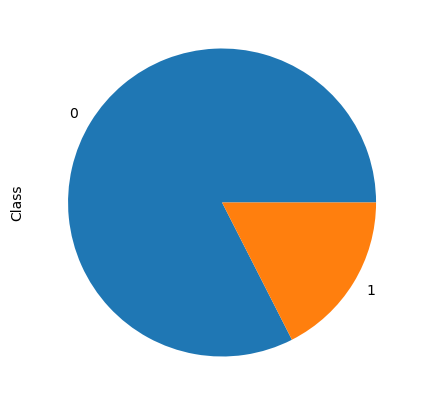

In [4]:
total_class = df['Class'].value_counts()
total_class.head()
fig, ax = plt.subplots(figsize=(5,5))
total_class.plot(kind='pie')

<h2>Now we make an algorithm to make a cross validation to

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

<h3>Remove non-numeric features</h3>

In [6]:
feature_numeric = [feature for feature in df.columns if feature not in ['Id', 'EJ']]
feature_numeric

['AB',
 'AF',
 'AH',
 'AM',
 'AR',
 'AX',
 'AY',
 'AZ',
 'BC',
 'BD ',
 'BN',
 'BP',
 'BQ',
 'BR',
 'BZ',
 'CB',
 'CC',
 'CD ',
 'CF',
 'CH',
 'CL',
 'CR',
 'CS',
 'CU',
 'CW ',
 'DA',
 'DE',
 'DF',
 'DH',
 'DI',
 'DL',
 'DN',
 'DU',
 'DV',
 'DY',
 'EB',
 'EE',
 'EG',
 'EH',
 'EL',
 'EP',
 'EU',
 'FC',
 'FD ',
 'FE',
 'FI',
 'FL',
 'FR',
 'FS',
 'GB',
 'GE',
 'GF',
 'GH',
 'GI',
 'GL',
 'Class']

In [7]:
dataset = df[feature_numeric]
dataset.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


<h2>Using KFolds for Cross Validation</h2>

<p>cross validation often used since it can help us provides a robust estimation of a model's performance and helps in selecting the best hyperparameter values</p>

In [8]:
num_folds = KFold(7)

<h3>OOF (Out Of Folds)</h3>

OOF is a process when we need to know the model performance while being on the folds

In [9]:
# Create list of ids for the creation of oof dataframe.
ID_LIST = dataset.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metircs for the models trained for each fold.
accuracy = {}
cross_entropy = {}

# Save the name of the label column to a variable.
label = "Class"

<h3>Check for Data Balanceness</h2>

In [10]:
neg, pos = np.bincount(dataset['Class'])
total_data = neg+pos

print(f'total: \n positives : {pos} is {100*pos/(total_data) : .2f}% of total data \n negatives = {neg} is {100*neg/total_data : .2f}% of total data')

total: 
 positives : 108 is  17.50% of total data 
 negatives = 509 is  82.50% of total data


since we can see that the data is totally imbalance, we need to do something to make the "class" is balanced

<h3>Balancing Process</h3>

the reasons why balanced data is a must in term of training model is imbalanced data will led to bias in model prediction and can affect the learning dynamics of machine learning algorithms. Imbalanced data can result in longer training times, as the model takes longer to converge due to the dominance of the majority class

calculate class weight manually

In [11]:
'''
weight_for_0 = (1 / neg) * (total_data/ 2.0)
weight_for_1 = (1 / pos) * (total_data/ 2.0)
#'''

#'''
weight_for_0 = total_data/(2*neg)
weight_for_1 = total_data/(2*pos)
#'''


weight_for_class = {0: weight_for_0, 1: weight_for_1}

print(f'Weight for class 0: {weight_for_0 :.2f} \nWeight for class : {weight_for_1 :.2f}')

Weight for class 0: 0.61 
Weight for class : 2.86


In [12]:
 np.unique(dataset['Class'])

array([0, 1])

In [13]:
dataset['Class']

0      1
1      0
2      0
3      0
4      1
      ..
612    0
613    0
614    0
615    0
616    0
Name: Class, Length: 617, dtype: int64

calculate class weight using SKlearn

In [14]:
classes = np.unique(dataset['Class'])
sklearn_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = classes, y=dataset['Class'])
sklearn_weights

array([0.60609037, 2.85648148])

In [15]:
sklearn_class_weight = {k: v for k, v in zip(classes, sklearn_weights)}
sklearn_class_weight

{0: 0.6060903732809431, 1: 2.8564814814814814}

<h3>Training Model</h3>

First we need to see what are the available models in Tensorflow Decision Forests

In [16]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [17]:
random_forests = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmp3rdtjese as temporary training directory


In [18]:
print(num_folds.split(X=dataset))

<generator object _BaseKFold.split at 0x788b35365070>


In [19]:
feature_used = [feature for feature in dataset.columns if feature not in ['Id']]
label
#feature_used

'Class'

In [20]:
for i, (train_index, valid_index) in enumerate(num_folds.split(X=dataset)):
        print('##### Fold',i+1)

        # Fetch values corresponding to the index 
        train = dataset.iloc[train_index]
        valid = dataset.iloc[valid_index]
        valid_id = valid.index.values
        
        # Select only feature columns for training.
        train = train[feature_used]
        valid = valid[feature_used]
        
        # convert dataset into tensorflow dataset
        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=label)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid, label=label)

        # Define the model and metrics
        random_forests = tfdf.keras.RandomForestModel()
        random_forests.compile(metrics=["accuracy", "binary_crossentropy"]) 
        
        # Train the model
        #class weight should be in dictionary format
        random_forests.fit(x=train_ds, class_weight=sklearn_class_weight)
        
        # Store the model
        models[f"fold_{i+1}"] = random_forests
        
        
        # Predict OOF value for validation data
        predict = random_forests.predict(x=valid_ds)
        
        # Store the predictions in oof dataframe
        oof.loc[valid_id, 0] = predict.flatten() 
        
        # Evaluate and store the metrics in respective dicts
        evaluation = random_forests.evaluate(x=valid_ds,return_dict=True)
        accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
        cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

##### Fold 1
Use /tmp/tmpec9jljnc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:06.180120. Found 528 examples.
Training model...
Model trained in 0:00:00.333369
Compiling model...


[INFO 23-07-15 04:10:40.4283 UTC kernel.cc:1242] Loading model from path /tmp/tmpec9jljnc/model/ with prefix 7c2e052503874fcc
[INFO 23-07-15 04:10:40.4833 UTC decision_forest.cc:660] Model loaded with 300 root(s), 14972 node(s), and 55 input feature(s).
[INFO 23-07-15 04:10:40.4833 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-15 04:10:40.4834 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 1s 637ms/step - loss: 0.0000e+00 - accuracy: 0.9775 - binary_crossentropy: 0.1927
##### Fold 2
Use /tmp/tmp_e3b4xhz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.004096. Found 529 examples.
Training model...
Model trained in 0:00:00.285718
Compiling model...


[INFO 23-07-15 04:10:45.1175 UTC kernel.cc:1242] Loading model from path /tmp/tmp_e3b4xhz/model/ with prefix db8e3968a75149a6
[INFO 23-07-15 04:10:45.1686 UTC decision_forest.cc:660] Model loaded with 300 root(s), 14330 node(s), and 55 input feature(s).
[INFO 23-07-15 04:10:45.1687 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 366ms/step - loss: 0.0000e+00 - accuracy: 0.9091 - binary_crossentropy: 0.2450
##### Fold 3
Use /tmp/tmplqg1_c0e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.994093. Found 529 examples.
Training model...
Model trained in 0:00:00.271070
Compiling model...


[INFO 23-07-15 04:10:47.5840 UTC kernel.cc:1242] Loading model from path /tmp/tmplqg1_c0e/model/ with prefix 09807a0510aa4b19
[INFO 23-07-15 04:10:47.6356 UTC decision_forest.cc:660] Model loaded with 300 root(s), 14578 node(s), and 55 input feature(s).
[INFO 23-07-15 04:10:47.6356 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 354ms/step - loss: 0.0000e+00 - accuracy: 0.8977 - binary_crossentropy: 0.2501
##### Fold 4
Use /tmp/tmpswvfxqau as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.958648. Found 529 examples.
Training model...
Model trained in 0:00:00.257254
Compiling model...


[INFO 23-07-15 04:10:49.9701 UTC kernel.cc:1242] Loading model from path /tmp/tmpswvfxqau/model/ with prefix 066e5707deda40f1
[INFO 23-07-15 04:10:50.0171 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13930 node(s), and 55 input feature(s).
[INFO 23-07-15 04:10:50.0172 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 353ms/step - loss: 0.0000e+00 - accuracy: 0.8977 - binary_crossentropy: 0.2848
##### Fold 5
Use /tmp/tmpsm4n0yk8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.925936. Found 529 examples.
Training model...
Model trained in 0:00:00.264605
Compiling model...


[INFO 23-07-15 04:10:52.3039 UTC kernel.cc:1242] Loading model from path /tmp/tmpsm4n0yk8/model/ with prefix 859c3b1e1ec948b0
[INFO 23-07-15 04:10:52.3537 UTC decision_forest.cc:660] Model loaded with 300 root(s), 14248 node(s), and 55 input feature(s).
[INFO 23-07-15 04:10:52.3538 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-15 04:10:52.3538 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 345ms/step - loss: 0.0000e+00 - accuracy: 0.9091 - binary_crossentropy: 0.2720
##### Fold 6
Use /tmp/tmp519hk8og as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.973806. Found 529 examples.
Training model...
Model trained in 0:00:00.270878
Compiling model...


[INFO 23-07-15 04:10:55.1691 UTC kernel.cc:1242] Loading model from path /tmp/tmp519hk8og/model/ with prefix e568c144dd2c4cf6
[INFO 23-07-15 04:10:55.2189 UTC decision_forest.cc:660] Model loaded with 300 root(s), 14386 node(s), and 55 input feature(s).
[INFO 23-07-15 04:10:55.2189 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 348ms/step - loss: 0.0000e+00 - accuracy: 0.9318 - binary_crossentropy: 0.2678
##### Fold 7
Use /tmp/tmp33anrdcb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.929792. Found 529 examples.
Training model...
Model trained in 0:00:00.270639
Compiling model...


[INFO 23-07-15 04:10:57.5222 UTC kernel.cc:1242] Loading model from path /tmp/tmp33anrdcb/model/ with prefix e80f60f3b6a24207
[INFO 23-07-15 04:10:57.5728 UTC decision_forest.cc:660] Model loaded with 300 root(s), 14916 node(s), and 55 input feature(s).
[INFO 23-07-15 04:10:57.5728 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 348ms/step - loss: 0.0000e+00 - accuracy: 0.9659 - binary_crossentropy: 0.1999


In [21]:
 tfdf.model_plotter.plot_model_in_colab(models['fold_7'], tree_idx=0, max_depth=7)


In [22]:
models

{'fold_1': <tensorflow_decision_forests.keras.RandomForestModel at 0x788b354d0280>,
 'fold_2': <tensorflow_decision_forests.keras.RandomForestModel at 0x788b3011c9d0>,
 'fold_3': <tensorflow_decision_forests.keras.RandomForestModel at 0x788b204851e0>,
 'fold_4': <tensorflow_decision_forests.keras.RandomForestModel at 0x788b300ca920>,
 'fold_5': <tensorflow_decision_forests.keras.RandomForestModel at 0x788b20755a80>,
 'fold_6': <tensorflow_decision_forests.keras.RandomForestModel at 0x788b203c03d0>,
 'fold_7': <tensorflow_decision_forests.keras.RandomForestModel at 0x788afbe407c0>}

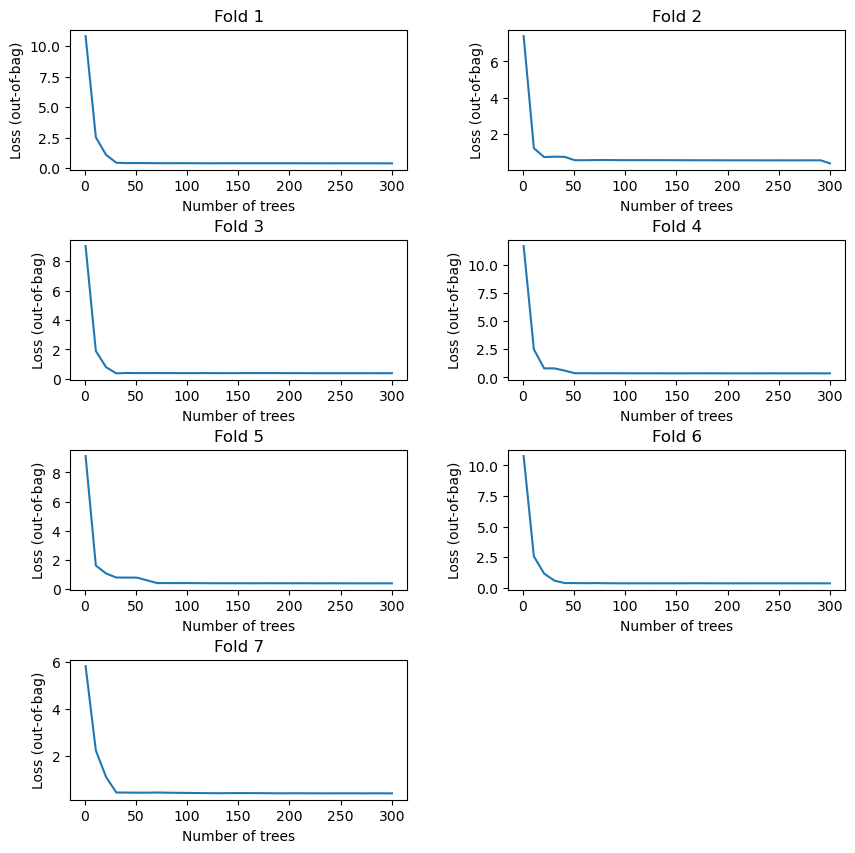

In [23]:
figure, axis = plt.subplots(4, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')
    
axis[3][1].set_visible(False)
plt.show()

In [24]:
inspector = models['fold_7'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_NODES
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT


In [25]:
important_features = inspector.variable_importances()['NUM_AS_ROOT']
tuplecoy = tuple(important_features)
important_feature = []
for item in tuplecoy:
    important_feature.append([item[0][0] , item[1]])
important_df = pd.DataFrame(important_feature, columns=['feature', 'score'])
important_df.head()

,feature,score
0,DU,46.0
1,FL,32.0
2,GL,32.0
3,BQ,21.0
4,CR,21.0


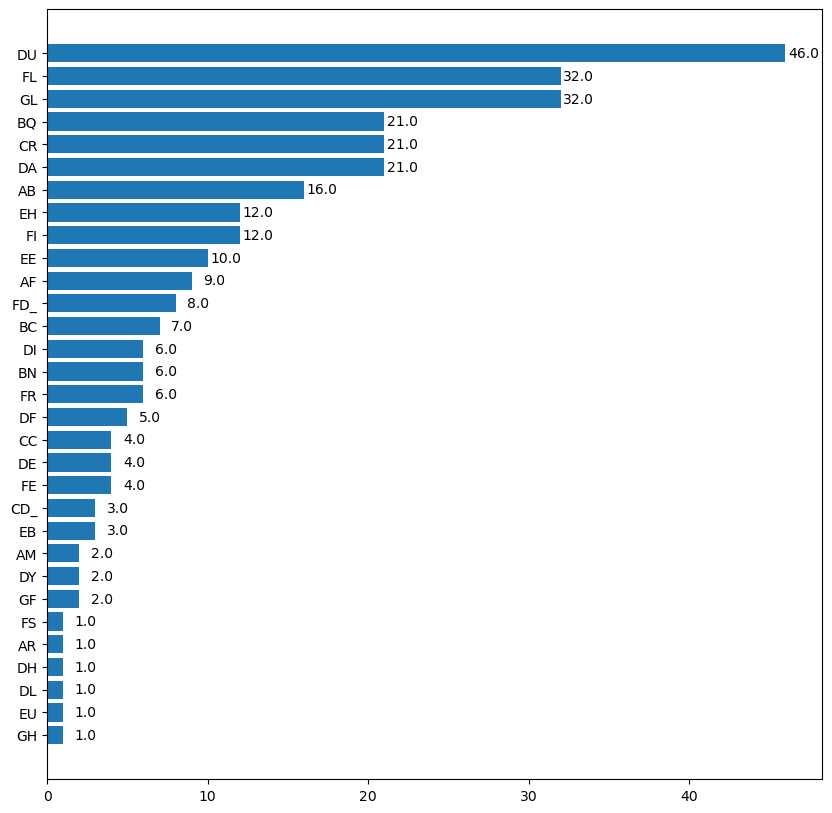

In [26]:
important_sorted = important_df.sort_values('score', ascending=True)
fig, ax = plt.subplots(figsize=(10, 10))
plt.barh(important_sorted['feature'],important_sorted['score'])
for i, v in enumerate(important_sorted['score']):
    plt.text(v+2.1, i, str(v), color='black', ha='right', va='center')

In [35]:
test = pd.read_csv("../input/icr-identify-age-related-conditions/test.csv")
test.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
test_feature = test.columns.to_list()
test_feature_used = [feature for feature in feature_used \
                    if feature in test_feature \
                    and feature != 'Id']
test_used = test[test_feature_used]
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_used)
predictions = models['fold_1'].predict(test_ds)
n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]
print(n_predictions)
#test_feature_used
#test_feature

1/1 [==============================] - 0s 146ms/step
[[0.67666689, 0.3233331], [0.67666689, 0.3233331], [0.67666689, 0.3233331], [0.67666689, 0.3233331], [0.67666689, 0.3233331]]
